In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [45]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bc0f27c278>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'id': 1}

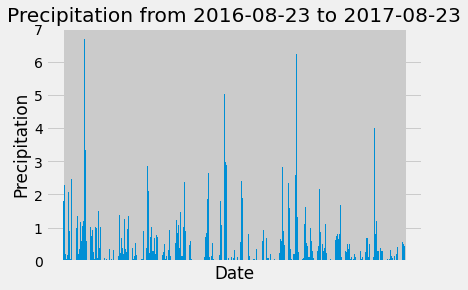

<Figure size 1440x1440 with 0 Axes>

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
MostRecentDate = "2017-08-23"

# Calculate the date one year from the last date in data set.
LastYearDate = dt.date(2017,8,23) - dt.timedelta(days=365)
#print (LastYearDate)

# Perform a query to retrieve the data and precipitation scores
Result = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= LastYearDate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitationWithDate_df = pd.DataFrame(Result,columns=['Date','Precipitation'])
precipitationWithDate_df = precipitationWithDate_df.set_index("Date")


# Sort the dataframe by date
precipitationWithDate_df = precipitationWithDate_df.sort_values(["Date"], ascending=True)
precipitationWithDate_df = precipitationWithDate_df.dropna(how='any') 
precipitationWithDate_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(precipitationWithDate_df.index,precipitationWithDate_df["Precipitation"])
plt.title(f"Precipitation from {LastYearDate} to {MostRecentDate}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tick_params(axis='x', labelbottom=False)
plt.figure(figsize = (20,20))
plt.show()




In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitationWithDate_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [49]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
StationResult = session.query(Measurement.station, func.count(Measurement.id)).\
     group_by(Measurement.station).\
     order_by(func.count(Measurement.id).desc()).all()
StationResult

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactivestation = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestation

(54.0, 85.0, 71.66378066378067)

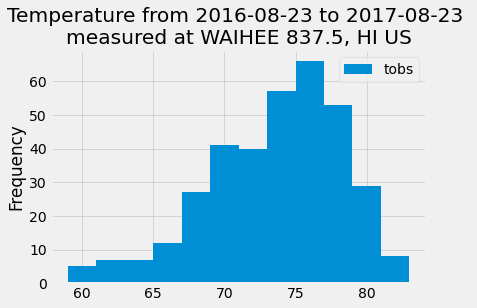

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostActiveStationid = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostActiveStationid = mostActiveStationid[0]
mostActiveStationid

mostactivestationidData = session.query(Measurement.tobs).\
    filter(Measurement.station == mostActiveStationid).\
    filter(Measurement.date >= LastYearDate).all()

MoveToList = list(np.ravel(mostactivestationidData)) 

stationInfo = pd.DataFrame(session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all())

stationname = stationInfo.loc[stationInfo["station"] == mostActiveStationid,"name"].tolist()[0]
plt.hist(MoveToList, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {LastYearDate} to {MostRecentDate} \nmeasured at {stationname}")
plt.legend()


# Close session

In [53]:
# Close Session
session.close()